In [1]:
%matplotlib inline 
import torch
import numpy
import torch.nn.functional as F
from nnClassifierModules import RNNSAClassifier
from nnEncoderModules import Radical2WordCNN
from preprocess import Vocab

In [2]:
data = [
    ('動物ものを見つけると癒されるので嬉しくなっちゃうよね。', 1),
    ('５００万本もの野生の水仙が風にそよぐ様は壮観。', 1),
    ('あたたかいメッセージ、本当にありがとうございます！', 1),
    ('いつもの商品と違った。', 0),
    ('小さ過ぎて、返品しました。',0),
    ('1年も使ってないのに、中の糸がほつれた。', 0),
]

In [3]:
def variableFromSentence(indexes):
    indexes.append('<eos>')
    result = Variable(torch.LongTensor(indexes))
    if use_cuda:
        return result.cuda()
    else:
        return result

In [4]:
vocab = Vocab(data, max_character_length=8, expand=True, keep_unseen_CHISEinfo=True, char_padding=True)

In [5]:
radical_vocab_size = len(vocab.radicals)
radical_emb_dim = 16
basic_filter_dim = 64
max_word_length = 4
max_sentence_length = 32
max_character_length = vocab.max_character_length
# build radical-level encoder for words. It output word vector by encoding radical embeddings.
t_radicalCNN = Radical2WordCNN(radical_vocab_size, radical_emb_dim, basic_filter_dim, max_word_length, max_character_length)
t_radicalCNN.cuda()

Radical2WordCNN(
  (radical_emb_lookup): Embedding(1188, 16)
  (radical_level_filter1): Sequential(
    (conv): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
    (activation): ReLU()
    (maxpooling): MaxPool1d(kernel_size=32, stride=32, padding=0, dilation=1, ceil_mode=False)
  )
  (radical_level_filter2): Sequential(
    (conv): Conv1d(16, 128, kernel_size=(2,), stride=(1,))
    (activation): ReLU()
    (maxpooling): MaxPool1d(kernel_size=31, stride=31, padding=0, dilation=1, ceil_mode=False)
  )
  (radical_level_filter3): Sequential(
    (conv): Conv1d(16, 192, kernel_size=(3,), stride=(1,))
    (activation): ReLU()
    (maxpooling): MaxPool1d(kernel_size=30, stride=30, padding=0, dilation=1, ceil_mode=False)
  )
  (char_level_filter1): Sequential(
    (conv): Conv1d(16, 64, kernel_size=(8,), stride=(8,))
    (activation): ReLU()
    (maxpooling): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (char_level_filter2): Sequential(
    (conv): Conv1d(16,

In [6]:
# Build a Word-level RNN
t_RNNSAC = RNNSAClassifier(word_embedding_dim=768, hidden_dim=256, target_size=2, max_input_length=max_sentence_length)
t_RNNSAC.cuda()

RNNSAClassifier(
  (lstm): LSTM(768, 256)
  (hidden2tag): Linear(in_features=256, out_features=2, bias=True)
  (self_attention): SelfAttention(
    (W): Linear(in_features=256, out_features=32, bias=True)
    (u): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [7]:
loss_function = torch.nn.NLLLoss().cuda()
optimizer = torch.optim.RMSprop(list(t_radicalCNN.parameters()) + list(t_RNNSAC.parameters()))
all_losses = []
plot_every = 1
current_loss = 0

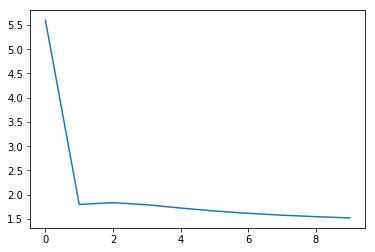

In [8]:
for epoch in range(10):
    # training
    for sentence, tag in data:
        optimizer.zero_grad()
        hidden = t_RNNSAC.init_hidden()
        # note: expect hier sentence in which all word is a sub seq
        words_input = torch.autograd.Variable(
            torch.LongTensor(vocab.sen2wr(sentence, max_sentence_length=max_sentence_length,max_word_length=max_word_length, hier=True)).cuda())
        words_feature = t_radicalCNN(words_input)
        target = torch.autograd.Variable(torch.LongTensor([tag]).cuda())
        tag_scores, _ = t_RNNSAC(words_feature, hidden)
        tag_scores = F.log_softmax(tag_scores, 0)
        loss = loss_function(tag_scores.unsqueeze(0), target)
        loss.backward()
        optimizer.step()

    # Validation
    for sentence, tag in data:
        t_RNNSAC.zero_grad()
        hidden = t_RNNSAC.init_hidden()
        words_input = torch.autograd.Variable(
            torch.LongTensor(vocab.sen2wr(sentence, max_sentence_length=max_sentence_length,max_word_length=max_word_length, hier=True)).cuda())
        words_feature = t_radicalCNN(words_input)
        target = torch.autograd.Variable(torch.LongTensor([tag]).cuda())
        tag_scores, _ = t_RNNSAC(words_feature, hidden)
        tag_scores = F.log_softmax(tag_scores, 0)
        loss = loss_function(tag_scores.unsqueeze(0), target)
        current_loss += loss.data.cpu().numpy()
    # for plotting loss
    current_loss += loss.data.cpu().numpy()
    if epoch % plot_every == 0:
        all_losses.append(current_loss / (plot_every * len(data)))
        current_loss = 0
        
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)